Analyst, Diplomat, Explorer tiplerinden 50'şer tane entry alınarak sample bir veriseti oluşturuldu. Bu veriseti "/home/khan/Desktop/sample_personality_dataset.csv" pathinde bulunmaktadır.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd 

In [0]:
df = pd.read_csv("gdrive/My Drive/mbti/all_users.csv", sep = ';', header = 0) 

In [4]:
df

,user,entry,type,typeClass,E,S,T,J,Unnamed: 8
0,19991991,ekşi itiraf 3,analysts,entj,1,0,1,1,NaN
1,19991991,duygularını belli etmeyen insan modeli bu beni...,analysts,entj,1,0,1,1,NaN
2,19991991,doğum günü resmi olarak kimlikte yazan doğum t...,analysts,entj,1,0,1,1,NaN
3,19991991,kendime not galiba dün akşam siz ne içtiniz de...,analysts,entj,1,0,1,1,NaN
4,19991991,ankaranın en güzel barı bkz fikrim ne biliyim ...,analysts,entj,1,0,1,1,NaN
...,...,...,...,...,...,...,...,...,...
639119,whiskylife,bağlaç olan de de ayrı yazılır takıntısı gerek...,sentinels,istj,0,1,1,1,NaN
639120,whiskylife,21 ocak 2017 liverpool swensea maçı 23 swansea...,sentinels,istj,0,1,1,1,NaN
639121,whiskylife,emily ratajkowski ortalamanın üstünde güzei ve...,sentinels,istj,0,1,1,1,NaN
639122,whiskylife,kanal dnin imdb puanı 3 olan filmler kuşağı iç...,sentinels,istj,0,1,1,1,NaN


Verisetinin class tiplerine göre dağılım

In [0]:
import matplotlib.pyplot as plt

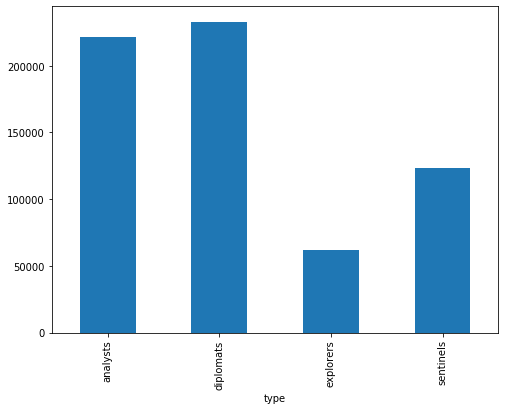

In [6]:
fig = plt.figure(figsize=(8,6))

df.groupby('type').type.count().plot.bar(ylim=0)
plt.show()

Türkçe için gerekli olan stop word listesi yoksa indirilir.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [8]:
nltk.download('stopwords')
stop_word_list = nltk.corpus.stopwords.words('turkish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
stop_word_list

['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

Preprocessing işlemleri yapılır. Burada bir tek Türkçe için stop words listesi kullanılarak girdilerden
gereksiz kelimeler atılır. TF-IDF özellik vektörü çıkarılır.

In [0]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stop_word_list, max_features=1000)

In [0]:
features = tfidf.fit_transform(df.entry).toarray()

In [35]:
labels = df.type
features.shape

(639124, 1000)

(x, y) -> x: döküman (entry) sayısı, y: kelime (vektör) sayısı
TF-IDF kullanarak çıkartılan özellik vektörü

In [0]:
#pd.set_option('display.max_rows', 20)
#pd.set_option('display.max_columns', 20)
#pd.set_option('display.width', 1000)

#features_df = pd.DataFrame(features)
#features_df

Multinominal (Birden fazla sınıflı) Naive Bayes modelinin oluşturulması. 

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['type'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

test_typeClass = y_test.values
   
predictions = clf.predict(count_vect.transform(X_test))

In [0]:
prediction_results = {'predicted': {}}  ## prediction_result['analysts'] means prediction is 'analysts'

prediction_results['predicted']['analysts']  = {'actual': {'analysts': 0, 'diplomats': 0, 'explorers': 0, 'sentinels': 0}}
prediction_results['predicted']['diplomats'] = {'actual': {'analysts': 0, 'diplomats': 0, 'explorers': 0, 'sentinels': 0}}
prediction_results['predicted']['explorers'] = {'actual': {'analysts': 0, 'diplomats': 0, 'explorers': 0, 'sentinels': 0}}
prediction_results['predicted']['sentinels'] = {'actual': {'analysts': 0, 'diplomats': 0, 'explorers': 0, 'sentinels': 0}}

## prediction_result['analysts']['diplomats'] means prediction is analysts but actual value is diplomats

In [0]:
for i in range(len(predictions)):
  predicted_value = predictions[i]
  actual_value = test_typeClass[i]
  prediction_results['predicted'][predicted_value]['actual'][actual_value] += 1

In [40]:
import json

print(json.dumps(prediction_results, indent = 2))

{
  "predicted": {
    "analysts": {
      "actual": {
        "analysts": 32029,
        "diplomats": 20189,
        "explorers": 6924,
        "sentinels": 14051
      }
    },
    "diplomats": {
      "actual": {
        "analysts": 23318,
        "diplomats": 38048,
        "explorers": 8326,
        "sentinels": 16777
      }
    },
    "explorers": {
      "actual": {
        "analysts": 0,
        "diplomats": 0,
        "explorers": 16,
        "sentinels": 0
      }
    },
    "sentinels": {
      "actual": {
        "analysts": 13,
        "diplomats": 9,
        "explorers": 8,
        "sentinels": 73
      }
    }
  }
}


In [41]:
results = prediction_results['predicted']
accuracy = (results['analysts']['actual']['analysts'] + results['diplomats']['actual']['diplomats'] + results['explorers']['actual']['explorers'] + results['sentinels']['actual']['sentinels']) / len(predictions)
accuracy

0.4391385709189453

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['E'], random_state = 0)  ## S, T, J
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

test_typeClass = y_test.values
   
predictions = clf.predict(count_vect.transform(X_test))

In [44]:
predictions

array([0, 0, 0, ..., 0, 1, 0])

In [47]:
predicted = {}
predicted['I'] = {'actual': {'I': 0, 'E': 0}}
predicted['E'] = {'actual': {'I': 0, 'E': 0}}
predicted

{'E': {'actual': {'E': 0, 'I': 0}}, 'I': {'actual': {'E': 0, 'I': 0}}}

In [0]:
int_to_class = ['I', 'E']

for i in range(len(predictions)):
  predicted_value = int_to_class[predictions[i]]
  actual_value = int_to_class[test_typeClass[i]]
  predicted[predicted_value]['actual'][actual_value] += 1


In [50]:
predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'I': {'actual': {'E': 53928, 'I': 72120}}}

In [0]:
accuracy = (predicted['E']['actual']['E'] + predicted['I']['actual']['I']) / len(predictions)

In [53]:
accuracy

0.5986193602493413

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['S'], random_state = 0)  ## T, J
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

test_typeClass = y_test.values
   
predictions = clf.predict(count_vect.transform(X_test))

In [56]:
predicted['N'] = {'actual': {'N': 0, 'S': 0}}
predicted['S'] = {'actual': {'N': 0, 'S': 0}}

predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'I': {'actual': {'E': 53928, 'I': 72120}},
 'N': {'actual': {'N': 0, 'S': 0}},
 'S': {'actual': {'N': 0, 'S': 0}}}

In [0]:
int_to_class = ['N', 'S']

for i in range(len(predictions)):
  predicted_value = int_to_class[predictions[i]]
  actual_value = int_to_class[test_typeClass[i]]
  predicted[predicted_value]['actual'][actual_value] += 1

In [61]:
predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'I': {'actual': {'E': 53928, 'I': 72120}},
 'N': {'actual': {'N': 113579, 'S': 46083}},
 'S': {'actual': {'N': 27, 'S': 92}}}

In [0]:
accuracy = (predicted['N']['actual']['N'] + predicted['S']['actual']['S']) / len(predictions)

In [60]:
accuracy

0.71141750270683

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['T'], random_state = 0)  ##  J
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

test_typeClass = y_test.values
   
predictions = clf.predict(count_vect.transform(X_test))

In [63]:
predicted['T'] = {'actual': {'T': 0, 'F': 0}}
predicted['F'] = {'actual': {'T': 0, 'F': 0}}

predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'F': {'actual': {'F': 0, 'T': 0}},
 'I': {'actual': {'E': 53928, 'I': 72120}},
 'N': {'actual': {'N': 113579, 'S': 46083}},
 'S': {'actual': {'N': 27, 'S': 92}},
 'T': {'actual': {'F': 0, 'T': 0}}}

In [0]:
int_to_class = ['F', 'T']

for i in range(len(predictions)):
  predicted_value = int_to_class[predictions[i]]
  actual_value = int_to_class[test_typeClass[i]]
  predicted[predicted_value]['actual'][actual_value] += 1

In [65]:
predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'F': {'actual': {'F': 39202, 'T': 22159}},
 'I': {'actual': {'E': 53928, 'I': 72120}},
 'N': {'actual': {'N': 113579, 'S': 46083}},
 'S': {'actual': {'N': 27, 'S': 92}},
 'T': {'actual': {'F': 41155, 'T': 57265}}}

In [0]:
accuracy = (predicted['F']['actual']['F'] + predicted['T']['actual']['T']) / len(predictions)

In [68]:
accuracy

0.6037451261414061

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['entry'], df['J'], random_state = 0) 
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

test_typeClass = y_test.values
   
predictions = clf.predict(count_vect.transform(X_test))

In [77]:
predicted['J'] = {'actual': {'J': 0, 'P': 0}}
predicted['P'] = {'actual': {'J': 0, 'P': 0}}

predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'F': {'actual': {'F': 39202, 'T': 22159}},
 'I': {'actual': {'E': 53928, 'I': 72120}},
 'J': {'actual': {'J': 0, 'P': 0}},
 'N': {'actual': {'N': 113579, 'S': 46083}},
 'P': {'actual': {'J': 0, 'P': 0}},
 'S': {'actual': {'N': 27, 'S': 92}},
 'T': {'actual': {'F': 41155, 'T': 57265}}}

In [0]:
int_to_class = ['P', 'J']

for i in range(len(predictions)):
  predicted_value = int_to_class[predictions[i]]
  actual_value = int_to_class[test_typeClass[i]]
  predicted[predicted_value]['actual'][actual_value] += 1

In [79]:
predicted

{'E': {'actual': {'E': 23528, 'I': 10205}},
 'F': {'actual': {'F': 39202, 'T': 22159}},
 'I': {'actual': {'E': 53928, 'I': 72120}},
 'J': {'actual': {'J': 30787, 'P': 19379}},
 'N': {'actual': {'N': 113579, 'S': 46083}},
 'P': {'actual': {'J': 46909, 'P': 62706}},
 'S': {'actual': {'N': 27, 'S': 92}},
 'T': {'actual': {'F': 41155, 'T': 57265}}}

In [0]:
accuracy = (predicted['P']['actual']['P'] + predicted['J']['actual']['J']) / len(predictions)

In [81]:
accuracy

0.5851321496298058

In [82]:
prediction_results['predicted'] = predicted

prediction_results

{'predicted': {'E': {'actual': {'E': 23528, 'I': 10205}},
  'F': {'actual': {'F': 39202, 'T': 22159}},
  'I': {'actual': {'E': 53928, 'I': 72120}},
  'J': {'actual': {'J': 30787, 'P': 19379}},
  'N': {'actual': {'N': 113579, 'S': 46083}},
  'P': {'actual': {'J': 46909, 'P': 62706}},
  'S': {'actual': {'N': 27, 'S': 92}},
  'T': {'actual': {'F': 41155, 'T': 57265}}}}